# **PROYECTO HUMOR** Modelo Binario con LSTM

**Autores:**

* Juan Camilo Acosta Rojas - 202324893
* Samuel Goncalves Vergara - 202122595
* Jefferson Hernández - 202120242
* Juan Andrés Mendez - 201815808

In [1]:
# Importación de librerias de python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

# Scikit-learn: División de datos y otras utilidades para machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# TensorFlow / Keras: Construcción y entrenamiento de redes neuronales
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model

# Conexión con drive para obtener el dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Carga de los datos**

Primero, se extraen los 10000 datos chistosos y los otros 10000 datos no chistosos. En total son 20000 registros.

In [2]:
url_graceful_dataset = "/content/drive/MyDrive/proyecto NLP/humor_dataset.csv"
url_non_graceful_dataset = "/content/drive/MyDrive/proyecto NLP/datosNochistosos.csv"

df_graceful = pd.read_csv(url_graceful_dataset)
df_non_graceful = pd.read_csv(url_non_graceful_dataset)

dataset = pd.concat([df_graceful, df_non_graceful])
dataset['Es_gracioso'] = dataset['Es_gracioso'].fillna(0)

# Se muestra 5 ejemplos aleatorios del dataset donde la columna "Es_gracioso" indica si es chistoso o no.
print(dataset.shape)
dataset.sample(n=3)

(20000, 20)


,id,text,Fuente,es_gracioso_p1,es_gracioso_p2,es_gracioso_p3,Es_gracioso,nivel_gracia_p1,nivel_gracia_p2,nivel_gracia_p3,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
9355,tweet14163,sete #JFCJustinBieber,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7959,tweet11984,Buenos días Terremoters,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
9587,tweet14497,Todo lo que necesito en esta vida es que tu me...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


## **2. Preprocesamiento de los datos**

Segundo, para el preprocesamiento usamos varios pasos. Primero se reemplazan URLs, menciones de usuarios, hashtags y emojis por tokens genéricos (<URL'>, <USUARIO'>, <HASH_TAG'>, <EMOJI'>), lo que reduce la dimensionalidad del texto sin perder contexto. Además, se convierte todo a minúsculas para uniformidad, se eliminan signos de puntuación y nombres de archivos irrelevantes.

In [3]:
"""
Función para limpiar un texto (chiste) que entra por parámetro
"""
def preprocess_text(text):
    # Transformación de las URLs a su token <URL>
    text = re.sub(r'http\S+', '<URL>', text)

    # Transformación de las menciones de usaurio a su token <USUARIO>
    text = re.sub(r'@\w+', '<USUARIO>', text)

    # Dejar en miniscula el texto
    text = text.lower()

    # Eliminar emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+', '', text)
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-\(|:-\*|:-\)|:P|:D|:<|:-P', '<EMOJI>', text)

    # Transformación de los hashtags a su token <HASH_TAG>
    text = re.sub(r'#\w+', '<HASH_TAG>', text)

    # Eliminar puntuación
    text = re.sub(r'[^\w\s]', '', text)

    # Transformación de las imagenes a su token <IMAGE>
    result = re.sub(r"[\w-]+\.(jpg|jpeg|png|gif):", "<IMAGE>", text)

    return text

dataset['text'] = dataset['text'].apply(preprocess_text)
dataset = dataset[['text', 'Es_gracioso']]
dataset.sample(n=3)

,text,Es_gracioso
9649,a qué hora informan el acontecer nacional y no...,0.0
1386,ahora más lacra y menos hippie porque entendí ...,0.0
5565,las series de moda siempre llegan con recomend...,1.0


## **3. Partición de los datos**

Tercero, se realiza una revisión de la distribución de los datos para verificar un correcto balanceo de las clases.

In [4]:
"""
Función para graficar la distribución de los datos
"""
def graficar_distribucion(class_counts):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d", hue=class_counts.index)

    # Añadir los números sobre las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title("Distribución de Clases en el Conjunto de Datos")
    plt.xlabel("Clase")
    plt.ylabel("Número de Muestras")
    plt.xticks(rotation=0)
    plt.legend([], [], frameon=False)
    plt.show()

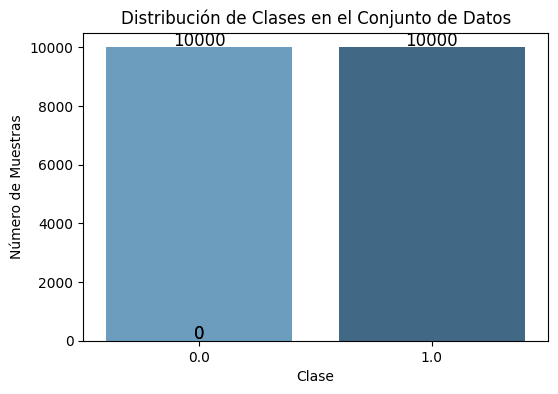

In [5]:
# Distribución de los datos de cada clase
graficar_distribucion(dataset['Es_gracioso'].value_counts())

Una vez verificado el correcto balanceo de las clase, se hace la partición de los datos dejando un 70% de los datos para entrenamiento, un 15% de los datos para validación y un 15% de los datos para prueba.

In [6]:
# Divide el dataset original en un cojunto entrenamiento y un conjunto auxliar
X_train, X_aux, y_train, y_aux = train_test_split(
    dataset['text'],
    dataset['Es_gracioso'],
    random_state=2024,
    test_size=0.3,
    stratify=dataset['Es_gracioso']
)

# Divide el conjunto auxiliar en un cojunto de prueba y un cojunto de validación
X_val, X_test, y_val, y_test = train_test_split(
    X_aux,
    y_aux,
    random_state=2024,
    test_size=0.5,
    stratify=y_aux
)

Una vez que los datos han sido particionados en conjuntos de entrenamiento, validación y prueba, se procede a realizar la tokenización del texto. Durante esta etapa, cada chiste se convierte en una secuencia de índices numéricos, donde cada número representa una palabra o token específico del vocabulario construido a partir del conjunto de entrenamiento.

Para garantizar que todas las secuencias tengan la misma longitud y puedan ser procesadas por el modelo LSTM, se aplica un paso adicional llamado padding, que rellena las secuencias más cortas con ceros hasta alcanzar una longitud fija (determinada por la longitud máxima en los datos de entrenamiento). Esto asegura que el modelo pueda procesar los datos de manera uniforme y eficiente.

In [7]:
"""
Función para generar el padding para cada conjunto de datos
"""
def tokenize_texts(tokenizer, texts, maxlen):
    # Convertir textos a secuencias de índices
    sequences = tokenizer.texts_to_sequences(texts)

    # Padding para asegurar longitud uniforme
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    return padded_sequences

# Crear y entrenar el tokenizador en el conjunto de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Tamaño del vocabulario:", vocab_size)

# Define una longitud máxima, basada en las secuencias de entrenamiento
MAX_LEN = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train))

# Tokenizar y aplicar padding
X_train_seq = tokenize_texts(tokenizer, X_train, maxlen=MAX_LEN)
X_val_seq = tokenize_texts(tokenizer, X_val, maxlen=MAX_LEN)
X_test_seq = tokenize_texts(tokenizer, X_test, maxlen=MAX_LEN)

Tamaño del vocabulario: 23790


## **4. Construcción y entrenamiento del modelo**

Cuarto, se realiza la definición del modelo secuencial en Keras compuesto por cuatro capas principales:

* **Capa de entrada (Input):** Acepta secuencias de longitud 20 como entrada, representadas como enteros.

* **Capa de embedding (Embedding):** Convierte los índices de palabras (hasta un vocabulario de 23790 palabras) en vectores de 50 dimensiones, proporcionando una representación densa de las palabras.

* **Capa LSTM:** Una red recurrente con 100 unidades, capaz de capturar relaciones y patrones secuenciales en los datos.

* **Capa de salida (Dense):** Produce una salida escalar con activación sigmoide, ideal para tareas de clasificación binaria.

In [8]:
model = Sequential([
    # Capa de entrada
    tf.keras.Input(shape=(20,), dtype="int64"),

    # Capa de embedding
    Embedding(input_dim=vocab_size, output_dim=50),

    # Capa LSTM
    LSTM(100),

    # Capa salida
    Dense(1, activation='sigmoid')
])

El modelo se compila con el optimizador Adam, la función de pérdida binary_crossentropy (adecuada para clasificación binaria) y la métrica accuracy para evaluar el rendimiento.

In [9]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 50)              │       1,189,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,250,001 (4.77 MB)

 Trainable params: 1,250,001 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

Se definen los siguiente callbacks para el proceso de entrenamiento:

* **EarlyStopping:** Detiene el entrenamiento si la pérdida en validación (val_loss) no mejora después de 10 épocas.

* **ModelCheckpoint:** Guarda el mejor modelo basado en la pérdida mínima en validación (val_loss) en un archivo con el nombre especificado.

In [10]:
"""
Función para definir dos callbacks para el entranmiento (EarlyStopping y ModelCheckpoint)
"""
def callbacks_model():
  my_callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
      tf.keras.callbacks.ModelCheckpoint("model.keras", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
  ]

  return my_callbacks

Una vez definido el modelo, se hace el proceso de entramiento con 20 epocas y un batch_size de 64.

In [11]:
history = model.fit(
    X_train_seq, np.array(y_train),
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks_model()
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7095 - loss: 0.5282
Epoch 1: val_loss improved from inf to 0.35249, saving model to model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.7098 - loss: 0.5278 - val_accuracy: 0.8467 - val_loss: 0.3525
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8906 - loss: 0.2613
Epoch 2: val_loss did not improve from 0.35249
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.8906 - loss: 0.2613 - val_accuracy: 0.8533 - val_loss: 0.3587
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9589 - loss: 0.1235
Epoch 3: val_loss did not improve from 0.35249
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.9589 - loss: 0.1235 - val_accuracy: 0.8340 - val_loss: 0.4624
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9806 - loss: 0.0593
Epoch 4: val_loss did not improve from 0.35249
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.9806 - loss: 0.05

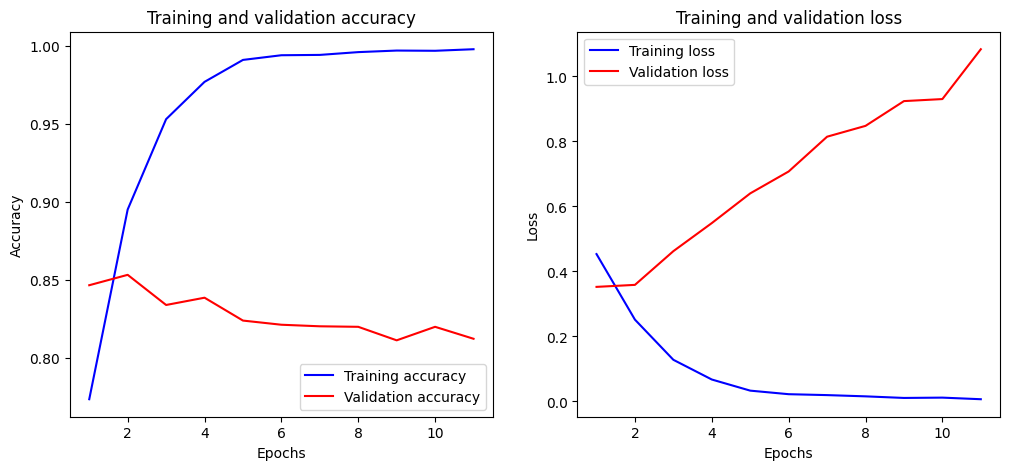

In [12]:
"""
Función para graficar los resultados del entramiento
"""
def plot_accuracy_and_loss(history):

    # Extraer datos de la historia de entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Número de épocas
    epochs = range(1, len(acc) + 1)

    # Gráfica de accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfica de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_accuracy_and_loss(history)

Una vez terminado el entrenamiento se carga el mejor modelo guardado por el callback de ModelCheckpoint.

In [13]:
# Carga del mejor modelo
model = load_model('model.keras')

## **5. Resultados del modelo**

Quinto, se procede a calcular la  matriz de confusión que arroja del modelo con respecto al conjunto de prueba. A partir de esta matriz, se derivan tres métricas importantes: precisión, recall y F1.

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Métricas derivadas de la matriz de confusión:
 - Precisión: 0.8562
 - Recall: 0.8180
 - F1: 0.8367


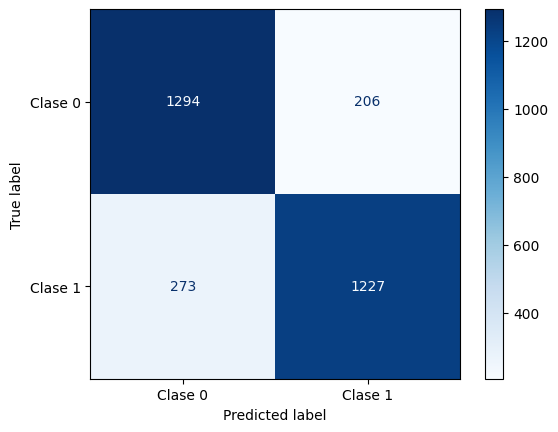

In [14]:
# Predecir etiquetas para el conjunto de prueba
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap="Blues")

# Calcular métricas adicionales basadas en la matriz de confusión
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Mostrar las métricas de la matriz de confusión
print("\nMétricas derivadas de la matriz de confusión:")
print(f" - Precisión: {precision:.4f}")
print(f" - Recall: {recall:.4f}")
print(f" - F1: {f1:.4f}")

Los resultados muestran una precisión de 0.8562, lo que indica que el 85.62% de las predicciones positivas fueron correctas. Un recall de 0.8180 sugiere que el modelo identificó correctamente el 81.80% de las instancias positivas. Finalmente, el F1 de 0.8367 refleja un buen equilibrio entre precisión y recall. Estos valores indican que el modelo tiene un rendimiento sólido, con un buen compromiso entre identificar correctamente los positivos y no cometer demasiados falsos positivos.